# Spectral Partitioning of Bipartite Graphs

---

Typical example of bipartite graph is a graph obtained from a collection of documents presented as a _term $\times$ document_  matrix.

## Prerequisites

The reader should be familiar with k-means algorithm and spectral graph partitioning theory and algorithms.
 
## Competences 

The reader should be able to apply spectral partitioning of bipartite graphs to data clustering problems.

__Credits__: The notebook is based on [I. Mirošević, Spectral Graph Partitioning and Application to Knowledge Extraction][Mir05].

[Mir05]: #1 "I. Mirošević, 'Spectral Graph Partitioning and Application to Knowledge Extraction', M.Sc. Thesis, Iniversity of Zagreb, 2005 (in Croatian)." 

---

## Definitions

__Undirected bipartite graph__ $G$ is a triplet 
$G=(T,D,E)$, where $T=\{t_{1},\cdots ,t_{m}\}$ and 
$D=\{d_{1},...,d_{n}\}$ are two sets of vertices and
$E=\{(t_{i},d_{j}):t_{i}\in R,d_{j}\in D\}$, 
is a set of edges.

$G$ is __weighted__ if there is weight $\omega(e)$ associated with each edge $e\in E$.

For example, $D$ is a set of documents, 
$T$ is a set of terms (words) and  edge $e=(t_{i},d_{j})$ exists if
document $d_{j}$ contains term $t_{i}$. Weight $\omega(e)$ can be number of appearances 
of the term $t_i$ in the document $d_j$.

A __term-by-document-matrix__ is a matrix $A\in\mathbb{R}^{m\times n}$ with 
$A_{ij}=\omega((t_i,d_j))$.

## Facts

1. The weight matrix of $G$ is $W=\begin{bmatrix}0 & A \\ A^{T} & 0 \end{bmatrix}$.

2. The Laplacian matrix of $G$ is 
$L=\begin{bmatrix} \Delta_{1} & -A \\ -A^{T} & \Delta_{2}\end{bmatrix}$,
where $\Delta_1$ and $\Delta_2$ are diagonal matrices with elements 
$\Delta_{1,ii}=\sum\limits_{j=1}^n A_{ij}$ for $i=1,\ldots,m$, and 
$\Delta_{1,jj}=\sum\limits_{i=1}^m A_{ij}$ for $j=1,\ldots,n$.

3. The normalized Laplacian matrix of $G$ is 
$L_n=\begin{bmatrix}
I & -\Delta_{1}^{-\frac{1}{2}}A\Delta_{2}^{-\frac{1}{2}} \\
-\Delta_{2}^{-\frac{1}{2}}A^T\Delta_{1}^{-\frac{1}{2}} & I
\end{bmatrix} \equiv 
\begin{bmatrix} I & -A_n \\ -A_n^T & I \end{bmatrix}$.

4. Let $\lambda$ be an eigenvalue of $L_n$ with an eigenvector 
$w=\begin{bmatrix} u \\ v\end{bmatrix}$, where 
$u\in \mathbb{R}^{m}$ $v\in\mathbb{R}^{n}$.
Then $L_n w=\lambda w$ implies
$A_n v =(1-\lambda)u$ and $A_n^T u=(1-\lambda)v$. Vice versa, if $(u,\sigma,v)$ is a singular triplet of $A_n$, then $1-\sigma$ is an eigenvalue of $L_n$ with (non-unit) eigenvector $w=\begin{bmatrix} u \\ v\end{bmatrix}$. 

5. The second largest singular value of $A_n$ corresponds to the second smallest eigenvalue of $L_n$, and computing the former is numerically more stable. 

5. _Bipartitioning algorithm_ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute singular vectors of $A_{n}$, $u^{[2]}$ and $v^{[2]}$, which correspond to 
    the second largest singular value, $\sigma_2(A_n)$.
    3. Assign the partitions $T=\{T_1,T_2\}$ and $D=\{D_1,D_2\}$ according to the signs of 
    $u^{[2]}$ and $v^{[2]}$. The pair $(T,D)$ is now partitioned as 
    $\{(T_1,D_1),(T_2,D_2)\}$.


6. _Recursive bipartitioning algorithm_ is the following:
    1. Compute the bipartition $\pi=\{(T_1,D_1),(T_2,D_2)\}$ of 
    $(T,D)$. Set the counter $c=2$.
    2. While $c<k$ repeat
         1. compute bipartitions of each of the subpartitions of $(T,D)$,
         2. among all $(c+1)$-subpartitions, choose the one with the smallest 
         $pcut(\pi_{c+1})$ or $ncut(\pi_{c+1})$, respectively.
    3. Set $c=c+1$
    3. Stop

7. _Multipartitioning algorithm_ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute $k$ left and right singular vectors, $u^{[1]},\ldots,u^{[k]}$ and 
    $v^{[1]},\ldots,v^{[k]}$, which correspond to $k$ largest singular values 
    $\sigma_1\geq \cdots \geq \sigma_k$ of $A_n$.
    3. Partition the rows of matrices 
    $\Delta_{1}^{-\frac{1}{2}}\begin{bmatrix} u^{[1]} & \ldots & u^{[k]}\end{bmatrix}$
    and 
    $\Delta_{2}^{-\frac{1}{2}}\begin{bmatrix} v^{[1]} & \ldots & v^{[k]}\end{bmatrix}$
    with the k-means algorithm.

### Example - Small term-by- document matrix

In [2]:
using Graphs
using IJuliaPortrayals
using Clustering

In [3]:
# Sources, targets, and weight
dn=[6,6,6,7,7,7]
tn=[1,2,3,2,4,5]
wn=[3,1,2,3,2,3]
[dn tn wn]

6×3 Array{Int64,2}:
 6  1  3
 6  2  1
 6  3  2
 7  2  3
 7  4  2
 7  5  3

In [4]:
G = inclist(ExVertex, ExEdge{ExVertex}; is_directed=false)
for i=1:5
    add_vertex!(G, ExVertex(i,"$i"))
    attrs=attributes(G.vertices[i],G)
    attrs["label"]="Term $i"
end

for i=1:2
    add_vertex!(G, ExVertex(i+5,"$(i+5)"))
    attrs=attributes(G.vertices[i+5],G)
    attrs["label"]="Document $i"
end

for i=1:6
    add_edge!(G, vertices(G)[dn[i]], vertices(G)[tn[i]])
end
for i=1:length(G.inclist)
    for j=1:length(G.inclist[i])
        ei=G.inclist[i][j]
        attrs = attributes(ei, G)
        attrs["label"] = wn[edge_index(ei,G)]
    end
end

In [6]:
# Plot
GraphViz(to_dot(G),"fdp","svg")

IJuliaPortrayals.GraphViz("graph graphname {\n1 [\"label\"=\"Term 1\"]\n1 -- 6 [\"label\"=\"3\"]\n2 [\"label\"=\"Term 2\"]\n2 -- 6 [\"label\"=\"1\"]\n2 -- 7 [\"label\"=\"3\"]\n3 [\"label\"=\"Term 3\"]\n3 -- 6 [\"label\"=\"2\"]\n4 [\"label\"=\"Term 4\"]\n4 -- 7 [\"label\"=\"2\"]\n5 [\"label\"=\"Term 5\"]\n5 -- 7 [\"label\"=\"3\"]\n6 [\"label\"=\"Document 1\"]\n7 [\"label\"=\"Document 2\"]\n}\n","fdp","svg")

In [7]:
W=weight_matrix(G,wn)

7×7 Array{Int64,2}:
 0  0  0  0  0  3  0
 0  0  0  0  0  1  3
 0  0  0  0  0  2  0
 0  0  0  0  0  0  2
 0  0  0  0  0  0  3
 3  1  2  0  0  0  0
 0  3  0  2  3  0  0

In [8]:
A=W[1:5,6:7]
Δ1=sqrt(sum(A,2))
Δ2=sqrt(sum(A,1))
An=map(Float64,[A[i,j]/(Δ1[i]*Δ2[j]) for i=1:size(A,1), j=1:size(A,2)])

5×2 Array{Float64,2}:
 0.707107  0.0     
 0.204124  0.53033 
 0.57735   0.0     
 0.0       0.5     
 0.0       0.612372

In [9]:
# The partitioning - explain the results!
U,σ,V=svd(An)

(
[-0.46291 0.604743; -0.534522 -0.218218; … ; -0.377964 -0.370328; -0.46291 -0.453557],

[1.0,0.883883],
[-0.654654 0.755929; -0.755929 -0.654654])

### Example - Sets of points

In [10]:
using Gadfly
using Images

In [11]:
?sprand

search: sprand sprandn sprandbool StepRange sparse2adjacencylist



```
sprand([rng],[type],m,[n],p::AbstractFloat,[rfn])
```

Create a random length `m` sparse vector or `m` by `n` sparse matrix, in which the probability of any element being nonzero is independently given by `p` (and hence the mean density of nonzeros is also exactly `p`). Nonzero values are sampled from the distribution specified by `rfn` and have the type `type`. The uniform distribution is used in case `rfn` is not specified. The optional `rng` argument specifies a random number generator, see [Random Numbers](:ref:`Random Numbers <random-numbers>`).


In [12]:
# Define sizes
m=[200,100,100]
n=[100,200,100]
density=[0.5,0.7,0.4]
A=Array(Any,3)
for i=1:3
    A[i]=sprand(m[i],n[i],density[i])
end
B=blkdiag(A[1],A[2],A[3])

400×400 sparse matrix with 28160 Float64 nonzero entries:
	[3  ,   1]  =  0.998505
	[5  ,   1]  =  0.121728
	[6  ,   1]  =  0.458352
	[8  ,   1]  =  0.874381
	[9  ,   1]  =  0.802965
	[11 ,   1]  =  0.712656
	[12 ,   1]  =  0.0569408
	[16 ,   1]  =  0.13675
	[18 ,   1]  =  0.121532
	[20 ,   1]  =  0.850766
	⋮
	[372, 400]  =  0.325205
	[373, 400]  =  0.947988
	[375, 400]  =  0.271949
	[379, 400]  =  0.894277
	[385, 400]  =  0.783618
	[388, 400]  =  0.723599
	[389, 400]  =  0.226509
	[395, 400]  =  0.553076
	[396, 400]  =  0.237246
	[398, 400]  =  0.896562
	[400, 400]  =  0.356445

In [13]:
pB=spy(B)
draw(Gadfly.PNG("files/pB.png", 4inch, 4inch), pB)

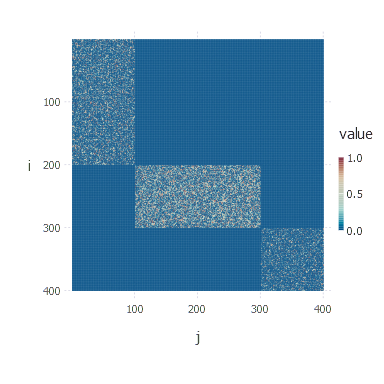

In [14]:
load("files/pB.png")

In [15]:
# The structure of singular vectors reflects the blocks
S,rest=svds(B,nsv=3)

(Base.LinAlg.SVD{Float64,Float64,Array{Float64,2}}([3.91522e-17 -0.0642016 1.95812e-18; 5.74969e-18 -0.0765712 2.50185e-17; … ; 1.22426e-17 7.36526e-18 -0.0955858; 2.29757e-17 -1.31424e-19 -0.0871817],[49.9859,35.8931,20.6931],[-5.89408e-17 -0.0941973 -8.28e-18; -4.51695e-17 -0.0935373 -1.05042e-17; … ; 3.10415e-17 -3.87398e-17 -0.0875405; 6.11939e-17 -3.62915e-17 -0.13565]),6,2,34,[-0.19542,-0.0770301,0.00251481,-0.180441,-0.0133296,0.0283623,-0.357038,0.0326151,-0.10275,0.0442144  …  0.209023,-0.00238597,0.180099,0.0938477,0.143084,0.0365106,0.164972,-0.112376,0.00611846,0.0490656])

In [16]:
# S is a structure
fieldnames(S)

3-element Array{Symbol,1}:
 :U 
 :S 
 :Vt

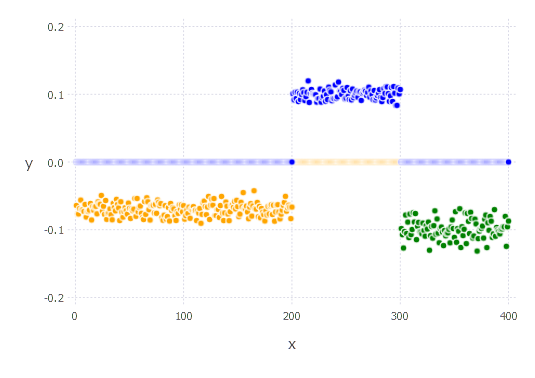

In [17]:
# Plot the first three left singular vectors
k=size(B,1)
x=collect(1:k)
Gadfly.plot(layer(x=x,y=S.U[:,1],Geom.point,Theme(default_color=colorant"blue")),
layer(x=x,y=S.U[:,2], Geom.point,Theme(default_color=colorant"orange")),
layer(x=x,y=S.U[:,3], Geom.point,Theme(default_color=colorant"green")))

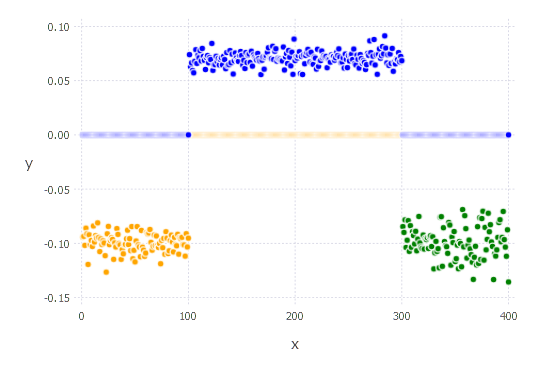

In [18]:
# Plot the first three right singular vectors
Gadfly.plot(layer(x=x,y=S.Vt[:,1],Geom.point,Theme(default_color=colorant"blue")),
layer(x=x,y=S.Vt[:,2], Geom.point,Theme(default_color=colorant"orange")),
layer(x=x,y=S.Vt[:,3], Geom.point,Theme(default_color=colorant"green")))

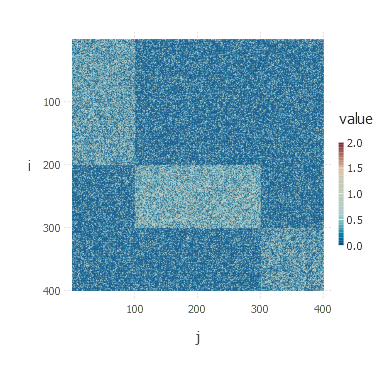

In [19]:
# Add random noise
noise=sprand(k,k,0.3)
C=B+noise
pC=spy(C)
draw(Gadfly.PNG("files/pC.png", 4inch, 4inch), pC)
load("files/pC.png")

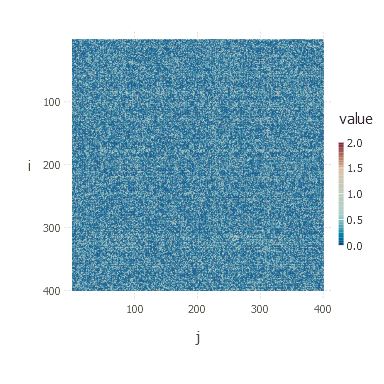

In [20]:
# Apply random permutation to rows and columns of C
D=C[randperm(k),randperm(k)]
pD=spy(D)
draw(Gadfly.PNG("files/pD.png", 4inch, 4inch), pD)
load("files/pD.png")

In [21]:
# Given D, we can recover C with spectral partitioning!!
S,rest=svds(D,nsv=3)

(Base.LinAlg.SVD{Float64,Float64,Array{Float64,2}}([0.0703367 -0.0736591 0.0224715; 0.0393228 0.0361331 0.0226469; … ; 0.0720177 -0.0812768 0.0298789; 0.0444246 0.040447 0.0274866],[98.7565,42.485,25.4979],[0.0425281 0.0151717 -0.0873831; 0.0462839 0.0715394 0.0292362; … ; 0.0499549 -0.0454218 -0.00463828; 0.04178 0.0362519 -0.120074]),6,3,42,[0.120244,0.283116,0.0545342,0.160979,-0.273596,-0.0626059,-0.0984818,0.0587834,0.479815,0.0189576  …  0.201534,-0.5842,0.0201492,0.175223,0.0711889,0.0259092,0.107401,0.163423,0.242351,0.0929773])

In [22]:
# Kmeans on rows and U and V
using Clustering

In [23]:
outU=kmeans((S.U)',3)

Clustering.KmeansResult{Float64}([0.0690453 0.0377318 0.0433497; -0.0695903 0.0169933 0.0478934; 0.0151419 -0.0883112 0.0261411],[1,3,3,3,2,2,1,2,2,2  …  3,3,2,1,2,2,2,1,1,3],[7.19459e-5,0.00016673,0.000227007,0.0002293,0.000497325,7.39623e-5,8.60579e-5,0.000429339,0.000631999,3.7148e-5  …  0.0001942,0.000784341,0.000117912,0.000307861,0.000276623,7.99782e-5,7.39062e-6,6.7066e-5,0.000362587,5.84157e-5],[100,100,200],[100.0,100.0,200.0],0.09366662541014938,2,true)

In [24]:
outV=kmeans((S.Vt)',3)

Clustering.KmeansResult{Float64}([0.0375327 0.0541427 0.0517579; 0.0248711 -0.0435036 0.0732432; -0.0856085 0.00983643 0.0413296],[1,3,1,2,1,1,1,3,1,3  …  2,3,2,1,2,1,1,3,2,1],[0.000122182,0.000179117,5.64943e-5,0.000487955,0.000801699,6.22546e-5,0.000186032,0.000340803,0.000216589,0.000830991  …  5.99674e-5,0.000134406,5.97778e-5,5.45137e-5,0.00126404,0.00255288,9.46961e-5,0.000113916,0.000230735,0.00133542],[100,200,100],[100.0,200.0,100.0],0.10508152144099882,4,true)

In [25]:
sortperm(outV.assignments)

400-element Array{Int64,1}:
   1
   3
   5
   6
   7
   9
  14
  16
  17
  19
  21
  25
  27
   ⋮
 344
 346
 356
 359
 360
 363
 367
 377
 384
 388
 392
 398

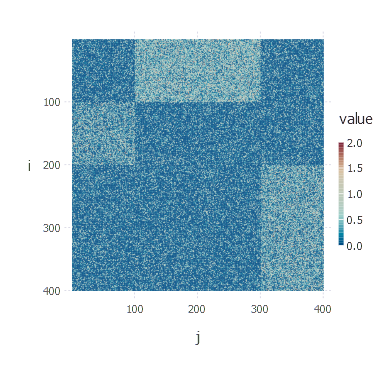

In [26]:
E=D[sortperm(outU.assignments),sortperm(outV.assignments)]
pE=spy(E)
draw(Gadfly.PNG("files/pE.png", 4inch, 4inch), pE)
load("files/pE.png")